# Developing a Recomender System for AMAZON Kindle_Store Data
By Krish Weragalarachchi

In [1]:
# The following statement installs pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install py4j
!pip install pyspark_dist_explore

     |████████████████████████████████| 198 kB 33.2 MB/s 


In [2]:
# install java
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()


In [3]:
# To use Spark and its API import the SparkContext
from pyspark import SparkContext
from pyspark.sql import SparkSession
# Create Spark Context
sc = SparkSession.builder.master("local[*]")\
     .config("spark.jars.packages", "org.apache.spark:spark-avro_2.12:3.1.2")\
     .getOrCreate()


# **Section 1**
## Data Understanding

In [4]:
# mount the google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# read the json data 
df_raw = sc.read.format("json").load("/content/drive/MyDrive/Kindle_Store_5.json")

In [6]:
# rows and columns
print((df_raw.count(), len(df_raw.columns)))

(982619, 9)


In [7]:
df_raw.show(5)

+----------+-------+-------+--------------------+-----------+--------------+--------------------+------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|           summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+--------------------+------------------+--------------+
|B000F83SZQ| [0, 0]|    5.0|I enjoy vintage b...| 05 5, 2014|A1F6404F1VG29J|          Avidreader|Nice vintage story|    1399248000|
|B000F83SZQ| [2, 2]|    4.0|This book is a re...| 01 6, 2014| AN0N05A9LIJEQ|            critters|      Different...|    1388966400|
|B000F83SZQ| [2, 2]|    4.0|This was a fairly...| 04 4, 2014| A795DMNCJILA6|                 dot|             Oldie|    1396569600|
|B000F83SZQ| [1, 1]|    5.0|I'd never read an...|02 19, 2014|A1FV0SX13TWVXQ|Elaine H. Turley ...|I really liked it.|    1392768000|
|B000F83SZQ| [0, 1]|    4.0|If you like perio...|03 19, 2014|A3SPTOKDG7WBLN|

following person will be use later for checking and final results.



In [8]:
import pyspark.sql.functions as f
df_raw.filter(f.col("reviewerID")=='A1ZCEJEA67P6DE').show()

+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|B004GNFNT0| [2, 2]|    5.0|After a bad read ...| 07 6, 2012|A1ZCEJEA67P6DE|Reading Renee "Re...|Excellent read wi...|    1341532800|
|B004LLIGNM| [1, 1]|    4.0|I was in need of ...|08 29, 2012|A1ZCEJEA67P6DE|Reading Renee "Re...|Adorable and roma...|    1346198400|
|B004TMMR1U| [0, 0]|    5.0|I really liked th...|08 15, 2012|A1ZCEJEA67P6DE|Reading Renee "Re...|Loved these spiri...|    1344988800|
|B005G7SUL8| [0, 0]|    5.0|Reincarnation doe...|08 15, 2012|A1ZCEJEA67P6DE|Reading Renee "Re...|I guess love para...|    1344988800|
|B005MT01D0| [0, 0]|    5.0|I am unbelievably...|06 16, 2013|A



There are 982,619 entries and 9 columns in the data set. We are interested in Product ID (asin), cutomer ID (reviewerID), rating(overall) and review (reviewText). 


#Data Wrangling
First, the columns that we are interested are selected and renamed to reflect the meaning.



In [9]:
df = df_raw

In [10]:
from pyspark.sql.functions import isnan, when, count, col
# get the columns of interest
df_data = df.select(col("asin").alias('product_ID'),\
                     col("reviewerID").alias('customer_ID'),\
                     col("overall").alias('rating'),\
                     col("reviewText").alias('review'))
df_data.show(3,False)

+----------+--------------+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|product_ID|customer_ID   |rating|review                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
+----------+------

In [18]:
# calculate sparsity of the dataset

products_raw = df_data.select('product_ID').distinct().count()

users_raw = df_data.select('customer_ID').distinct().count()


ratings_raw = df_data.select('rating').count()

sparsity_raw = (1.0 - (ratings_raw * 1.0)/ (users_raw*products_raw)) * 100

sparsity_raw

99.97674452498852

# Check for missing values and null values

In [14]:
# Get count of nan or missing values 
df_data.select([count(when(isnan(c), c)).alias(c) for c in df_data.columns]).show()

+----------+-----------+------+------+
|product_ID|customer_ID|rating|review|
+----------+-----------+------+------+
|         0|          0|     0|     0|
+----------+-----------+------+------+



In [15]:
# Get count of null values 

df_data.select([count(when(col(c).isNull(), c)).alias(c) for c in df_data.columns]).show()

+----------+-----------+------+------+
|product_ID|customer_ID|rating|review|
+----------+-----------+------+------+
|         0|          0|     0|     0|
+----------+-----------+------+------+



There are no 'nan' or missing values in the data set, neither any null values.

It is better to have less sparse customer - product matrix. one way to do this is by cleaning the data such that, it includes products with more than 30 rating and customers who gave more than 30 ratings. 


In [11]:
from pyspark.sql import functions as F
from pyspark.sql import Window
# products with more than 20 ratings 
window1 = Window.partitionBy("product_ID")

df_data1 = df_data.withColumn("count", F.count("rating").over(window1))\
    .filter(F.col("count") >= 20).drop("count")

In [12]:
# customers who gave more than 20 ratings 
from pyspark.sql import functions as F
from pyspark.sql import Window
window2 = Window.partitionBy("customer_ID")

df_data2 = df_data1.withColumn("count", F.count("rating").over(window2))\
    .filter(F.col("count") >= 20).drop("count")

#  core dataset
df_data2.count()

196190

## Number of unique products, customers, ratings in the data set

Now the data set is ready to analyze.

In [13]:
# cleaned data
df1 = df_data2

In [14]:
# number of ratings , products and users
products = df1.select('product_ID').distinct().count()

users = df1.select('customer_ID').distinct().count()

ratings_types = df1.select('rating').distinct().count()

ratings = df1.select('rating').count()

reviews = df1.count()-df_data.select([count(when(col('review').isNull(),True))]).collect()[0]['count(CASE WHEN (review IS NULL) THEN true END)']

print("Number of unique products =", products)
print("Number of unique users =", users)
print("Number of different rating types =", ratings_types)
print("Number of different ratings =", ratings)
print("Number of reviews =", reviews )

Number of unique products = 12291
Number of unique users = 4867
Number of different rating types = 5
Number of different ratings = 196190
Number of reviews = 196190


## Rating distribution

Let's look at the rating distribution.

In [21]:
df1.groupBy('rating').count().show()

+------+------+
|rating| count|
+------+------+
|   1.0|  2631|
|   4.0| 57308|
|   3.0| 20477|
|   2.0|  5591|
|   5.0|110183|
+------+------+



(array([1.000e+00, 1.000e+00, 1.200e+01, 2.600e+01, 6.800e+01, 2.210e+02,
        4.360e+02, 9.060e+02, 1.262e+03, 1.934e+03]),
 array([1.15555556, 1.54      , 1.92444444, 2.30888889, 2.69333333,
        3.07777778, 3.46222222, 3.84666667, 4.23111111, 4.61555556,
        5.        ]),
 <a list of 10 Patch objects>)

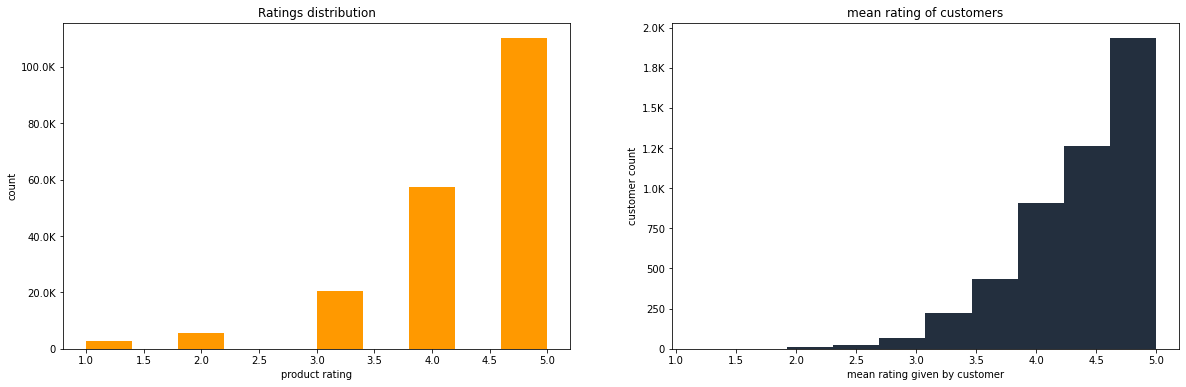

In [22]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax[0].title.set_text('Ratings distribution')
ax[0].set_xlabel('product rating')
ax[0].set_ylabel('count')
hist(ax[0], df1.select('rating'),bins =10, color=['#FF9900'])

meanratings = df1.groupBy("customer_ID").agg({"rating":"avg"})
ax[1].title.set_text('mean rating of customers')
ax[1].set_xlabel('mean rating given by customer')
ax[1].set_ylabel('customer count')
hist(ax[1], meanratings.select('avg(rating)'), bins = 10, color=['#232F3E'])

It is clear from the above graph that the rating distribution is highly skew to the right close to rating 5.0. It is very common in rating systems as unless a customer is really dissopointed, they will usually give 4 or 5. stars. 



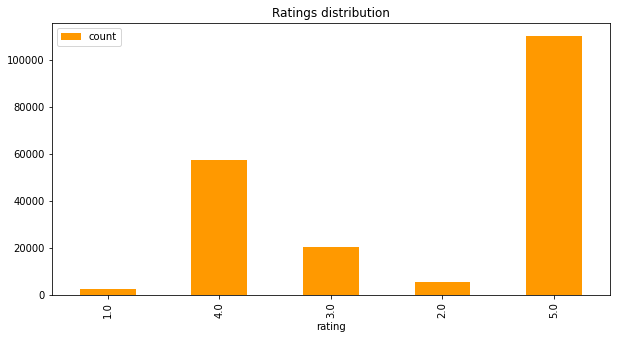

In [23]:
ratings_pandas = df1.groupBy('rating').count().toPandas()
ratings_pandas.plot(kind='bar', x='rating', y='count', color=['#FF9900'], figsize =(10,5), title = 'Ratings distribution')

In [24]:
df1.groupBy('customer_ID').count().sort(col('count').desc()).show(5)

+--------------+-----+
|   customer_ID|count|
+--------------+-----+
|A1JLU5H1CCENWX|  566|
| A2YJ8VP1SSHJ7|  406|
|A2VXSQHJWZAQGY|  322|
|A3IQ0P3M39IY8U|  310|
|A3A7FF87LEVCQ1|  283|
+--------------+-----+
only showing top 5 rows



Some customers have reviewed more than 400 products

In [25]:
df1.groupBy('customer_ID').count().sort(col('count').asc()).show(5)

+--------------+-----+
|   customer_ID|count|
+--------------+-----+
|A1AIZTWX7A7JZE|   20|
|A1CBSU5DTMYX3E|   20|
|A1PIHRVCTCJQFL|   20|
|A104X2ZLOG0MFE|   20|
| AG0YSOSHD182V|   20|
+--------------+-----+
only showing top 5 rows



In [26]:
df1.groupBy('product_ID').count().sort(col('count').desc()).show(5)

+----------+-----+
|product_ID|count|
+----------+-----+
|B00H0V069M|  221|
|B00JDYC5OI|  189|
|B00BTIDW4S|  184|
|B00DDXKA1U|  170|
|B00CCRTFSC|  168|
+----------+-----+
only showing top 5 rows



In [27]:
df1.groupBy('product_ID').count().sort(col('count').asc()).show(5)

+----------+-----+
|product_ID|count|
+----------+-----+
|B008IEJTSE|    1|
|B001BUPF62|    1|
|B00DOM12E4|    1|
|B007O3IKTY|    1|
|B00IJXAM80|    1|
+----------+-----+
only showing top 5 rows



## Section 2 

# Recommendation systems

Let’s see the sparsity of the customer-rating matrix




In [15]:
# sparcity after splicing
sparsity = (1.0 - (ratings * 1.0)/ (users*products)) * 100
print('The ratings dataframe is', '%.2f' % sparsity + '% empty.')
sparsity 

The ratings dataframe is 99.67% empty.


99.67203439327625

We need to have a baseline to compare any models that we make and here I choose the most basic recomendation based on mean value. 

In [16]:
from pyspark.sql.functions import mean as _mean 
# mean
mean_rating=df1.select(_mean(col('rating')).alias('mean')).collect()[0]['mean']
print("Mean rating =", mean_rating)

Mean rating = 4.360013252459351


In [17]:
# median
median_rating = df1.approxQuantile("rating", [0.5], 0)[0] 
print("Median rating =", median_rating)

Median rating = 5.0


In [18]:
# RMSE of baseline model based on median
baseline_rmse_median=pow((df1.select(_mean(pow(col('rating')- median_rating, 2)).alias('mean')).collect()[0]['mean']),0.5)
baseline_rmse_median

1.0865754977213182

In [19]:
# RMSE of baseline model based on mean
baseline_rmse_mean=pow((df1.select(_mean(pow(col('rating')-mean_rating, 2)).alias('mean')).collect()[0]['mean']),0.5)
baseline_rmse_mean

0.878102087015332

we can stick to the mean as baseline as it is better than considering the most common (median) as this particuler data set highly skewed. 



In [20]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

In [21]:
# we need to make product_id and customer_id to catogorical codes
indexers = [StringIndexer(inputCol="product_ID", outputCol="product_Index") , StringIndexer(inputCol="customer_ID", outputCol="customer_Index")]
pipeline = Pipeline(stages=indexers)
DF = pipeline.fit(df1).transform(df1)


In [22]:
# change type
type_df = DF.withColumn("customer_Index", DF["customer_Index"].cast("int"))
type_df = type_df.withColumn("product_Index", type_df["product_Index"].cast("int"))
type_df = type_df.withColumn("rating", type_df["rating"].cast("float"))
type_df.printSchema()


root
 |-- product_ID: string (nullable = true)
 |-- customer_ID: string (nullable = true)
 |-- rating: float (nullable = true)
 |-- review: string (nullable = true)
 |-- product_Index: integer (nullable = true)
 |-- customer_Index: integer (nullable = true)



# Populartity based recomendation system

Let's first make a popularity based recomender system. We first need to split the data in to testing and training sets.

This will reccommend the products with highest average rating to all customers regardless of their likes.

In [23]:
# train test split
(training, testing) = type_df.randomSplit([0.8, 0.2])

In [24]:
# calculate average rating for each product
training_av = training.groupBy('product_ID').mean("rating").sort(col('avg(rating)'))

In [25]:
# merge average values calculated using training data with testing data
# inner join excludes appearing null values 
test_train_av = testing.join(training_av, "product_ID", "inner")
test_train_av.show()

+----------+--------------+------+--------------------+-------------+--------------+------------------+
|product_ID|   customer_ID|rating|              review|product_Index|customer_Index|       avg(rating)|
+----------+--------------+------+--------------------+-------------+--------------+------------------+
|B004OEIRNA| A2YJ8VP1SSHJ7|   5.0|I think werewolve...|          603|             1|3.8333333333333335|
|B004OEIRNA| ANMSDY55VG8UK|   4.0|I enjoyed this st...|          603|          1953|3.8333333333333335|
|B004OEIRNA|A3D0MHNQMGK1E1|   5.0|Good shifter erot...|          603|           900|3.8333333333333335|
|B004OEIRNA|A3SPK0TJKKIL7W|   3.0|3.5 stars rounded...|          603|          1937|3.8333333333333335|
|B004OEIRNA|A3SUBHQ6PZ4RHQ|   4.0|Who knew there we...|          603|          2972|3.8333333333333335|
|B004OEIRNA| A320TMDV6KCFU|   4.0|More unique than ...|          603|            31|3.8333333333333335|
|B004OEIRNA| AK416MLKE1AH5|   1.0|when I started re...|         

*RMSE* of the popularity based recomender system




In [26]:
# RMSE of the popularity based recomender system
from pyspark.sql.functions import mean as _mean 

pop_rmse = pow((test_train_av.select(_mean(pow(col('rating')-col('avg(rating)'), 2)).alias('mean')).collect()[0]['mean']),0.5)
pop_rmse

0.8520582007092569

10 recomendations to any customer based on popularity based recommendation model

In [27]:
training_av.sort(col('avg(rating)').desc()).show(10)

+----------+-----------+
|product_ID|avg(rating)|
+----------+-----------+
|B00971BLY2|        5.0|
|B00HSV1ACG|        5.0|
|B007O3IKTY|        5.0|
|B007NLCJBC|        5.0|
|B0094P40JY|        5.0|
|B00IHBQVSY|        5.0|
|B00EBVD7EU|        5.0|
|B001BUPF62|        5.0|
|B00CDU1H98|        5.0|
|B00AHVNEPK|        5.0|
+----------+-----------+
only showing top 10 rows



# Collaborative recomendation system
collaborative filtering uses similarities between users and items to provide recommendations. collaborative filtering models recommend products to a user based on the interests of a similar user.

# 1. ALS model




from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
df_rdd = type_df.rdd
ratings= df_rdd.map(lambda l:Rating(int(l[5]),int(l[4]), float(l[2])))
X_train, X_test = ratings.randomSplit([0.8, 0.2])
rank = 2
numIterations = 5
model = ALS.train(X_train,rank, numIterations,nonnegative=True)
testdata = X_test.map(lambda x: [x[0],x[1]])
predictions = model.predictAll(testdata).map(lambda x: ((x[0], x[1]), x[2]))
ratesAndPreds = X_test.map(lambda x: ((x[0], x[1]), x[2])).join(predictions)
MSE = ratesAndPreds.map(lambda x: (x[1][0] - x[1][1])**2).mean()
print("Mean Squared Error = " + str(MSE))


In [28]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row


als = ALS(userCol="customer_Index", itemCol="product_Index", ratingCol="rating",
          coldStartStrategy="drop",nonnegative = True, implicitPrefs = False)

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
als_param_grid = ParamGridBuilder() \
 .addGrid(als.rank, [5, 10]) \
 .addGrid(als.maxIter, [5, 10]) \
 .addGrid(als.regParam, [.01, 0.1]) \
 .build()
# Define evaluator as RMSE
als_evaluator = RegressionEvaluator(metricName = 'rmse', labelCol = 'rating', predictionCol = 'prediction')
# Print length of evaluator
print ('Num models to be tested using param_grid: ', len(als_param_grid))


Num models to be tested using param_grid:  8


In [29]:

# Build cross validation using CrossValidator
als_cv = CrossValidator(estimator = als, estimatorParamMaps = als_param_grid, evaluator = als_evaluator, numFolds = 5)
als_model = als_cv.fit(training)
als_predictions = als_model.transform(testing)
als_predictions.show(n = 10)
# rmse
als_rmse = als_evaluator.evaluate(als_predictions)
print('Root-mean-square error = ' + str(als_rmse))

+----------+--------------+------+--------------------+-------------+--------------+----------+
|product_ID|   customer_ID|rating|              review|product_Index|customer_Index|prediction|
+----------+--------------+------+--------------------+-------------+--------------+----------+
|B00HXXE5Q2|A31XT9M2AQ772Z|   5.0|UGH!  So frustrat...|          148|          1510| 4.0964003|
|B00HXXE5Q2| A2Y0EXBTLBW99|   5.0|I loved this stor...|          148|           577| 5.0847235|
|B00HXXE5Q2|A3KF9GEKN2DXTU|   3.0|I liked the story...|          148|           685|   4.63249|
|B00HXXE5Q2|A23ODOI8AJBCDN|   5.0|Complicated chara...|          148|          1304|  3.860804|
|B00HXXE5Q2|A17APVES3TT17Y|   3.0|With all of the F...|          148|           212| 4.6780715|
|B00HXXE5Q2|A3TMD3W16REBOQ|   4.0|Love triangles&#8...|          148|           268| 4.2299867|
|B00HXXE5Q2|A3M8OP0ZHAQDLP|   4.0|This book was goo...|          148|          4409|  4.376687|
|B00HXXE5Q2|A3BVZ567DH6SRJ|   4.0|This w

In [30]:
# als prediction and actual rating
als_out = als_predictions.select(col("rating"),col("prediction")).toPandas()


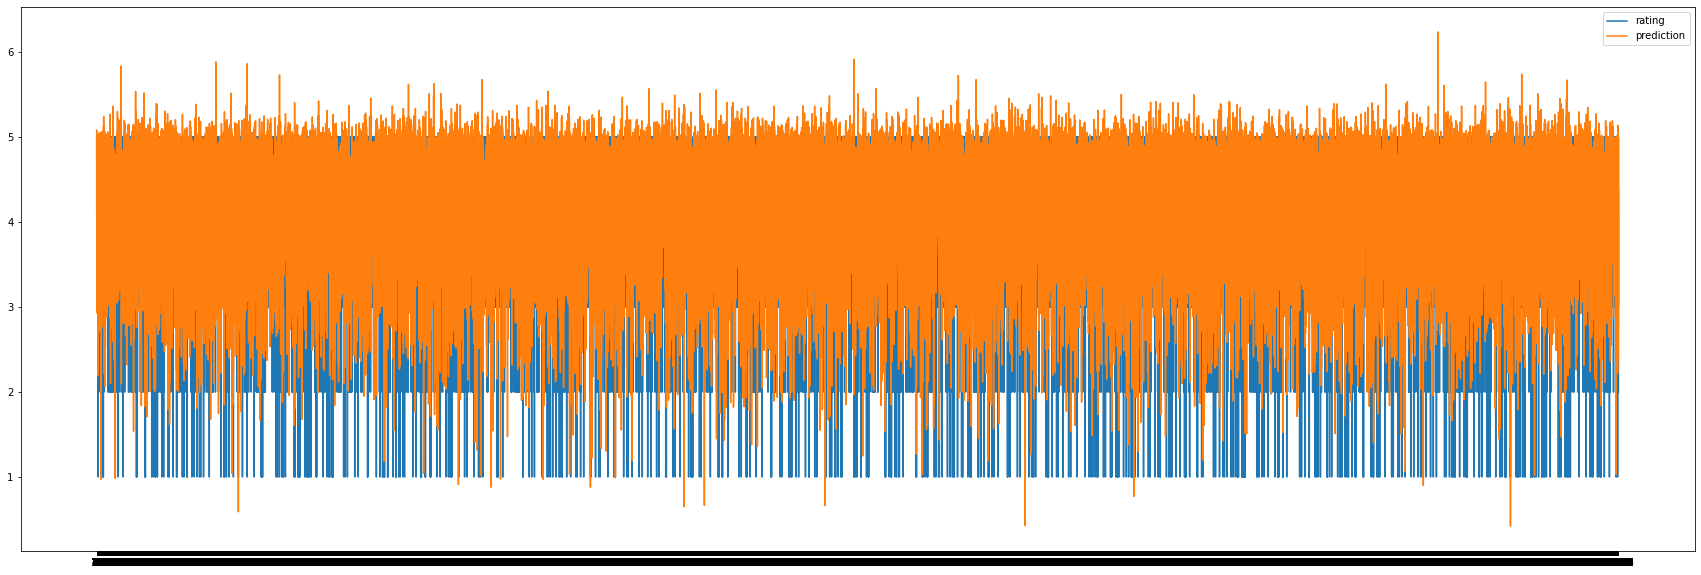

In [32]:
# plot als prediction and actual rating
als_out.plot(figsize=(30,10), xticks=range(len(als_out['rating'])))


[link text](https://)0.7690372336722585

# KNNWithMeans model

In [34]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
!pip install scikit-surprise

from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import split
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from collections import defaultdict

import json
import pandas as pd


     |████████████████████████████████| 11.8 MB 29.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619423 sha256=fcfa3515a8f053cdfc975cb8d8d1b089a4b3a10d074e0d54c0e594e247c84be2
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [35]:
from surprise import KNNBasic, KNNWithMeans, SVD

In [36]:
# to pandas
dff = df1.toPandas()
dataset = dff[['customer_ID','product_ID','rating']]
dataset

,customer_ID,product_ID,rating
0,A1CNQTCRQ35IMM,B00G8U2O0U,3.0
1,A1CNQTCRQ35IMM,B0055PMJMW,4.0
2,A1CNQTCRQ35IMM,B005D75Z8C,4.0
3,A1CNQTCRQ35IMM,B007FIIF34,2.0
4,A1CNQTCRQ35IMM,B00D4KG0DE,3.0
...,...,...,...
196185,AVRJUS10RM4CV,B00ICNBKN8,5.0
196186,AVRJUS10RM4CV,B0058OJ8AG,3.0
196187,AVRJUS10RM4CV,B00CAW3G66,4.0
196188,AVRJUS10RM4CV,B0064I72LC,4.0


In [38]:
reader = Reader(rating_scale=(1, 5)) # set rating scale from 1 to 5
data_m=Dataset.load_from_df(dataset,reader) #  dataset formated to use in surprise
trainset, testset = train_test_split(data_m, test_size=.20, random_state=1) # train-test split

In [74]:
# parameter search and cross validation
sim_options = {
    "name": ["msd", "cosine","pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [True],
    "k":[5,10]
    }
knn_param_grid = {"sim_options": sim_options,"verbose":[True,False]}
knnm_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=["rmse", "mae"],cv=5)
knnm_gs.fit(data_m)
knnm_rmse = knnm_gs.best_score["rmse"]
print('RMSE of KNNWithMeans',knnm_rmse)
print(knnm_gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

# KNNBasic model

In [75]:
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
# parameter search and cross validation
knnb_gs = GridSearchCV(KNNBasic, knn_param_grid, measures=["rmse", "mae"],cv=3)
knnb_gs.fit(data_m)
knnb_rmse = knnb_gs.best_score["rmse"]
print('RMSE of KNNBasic',knnb_rmse)
print(knnb_gs.best_params["rmse"])


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

# SVD Model

In [47]:
# parameter search and cross validation
svd_param_grid = {'n_epochs': [20, 25], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5)
svd_gs.fit(data_m)

svd_rmse = svd_gs.best_score["rmse"]
print('RMSE of SVD',svd_rmse)
print(svd_gs.best_params["rmse"])


RMSE of SVD 0.7127879263306851
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


In [39]:
# best svd 
best = SVD(n_epochs= 25,lr_all=0.01,reg_all= 0.4)
# train the model
best.fit(trainset)

In [40]:

# run the trained model against the testset
test_predictions = best.test(testset)
test_predictions

[Prediction(uid='A19KN4HDC6HXS7', iid='B00FJ3CPCO', r_ui=4.0, est=4.599940266945447, details={'was_impossible': False}),
 Prediction(uid='A3IRQCW03LJA0G', iid='B00DMKTEKC', r_ui=5.0, est=4.9793371575373175, details={'was_impossible': False}),
 Prediction(uid='A2SRUC3I2U1CAY', iid='B00KTK56P0', r_ui=5.0, est=4.626454845230328, details={'was_impossible': False}),
 Prediction(uid='A14FKPH3G9ESKD', iid='B00LBEQ3BY', r_ui=5.0, est=4.760345815810461, details={'was_impossible': False}),
 Prediction(uid='ALQGOMOY1F5X9', iid='B0080AGLEQ', r_ui=1.0, est=2.8358826602479725, details={'was_impossible': False}),
 Prediction(uid='A3PATLW8T3PQV7', iid='B00BOTU4JI', r_ui=5.0, est=4.231299805911325, details={'was_impossible': False}),
 Prediction(uid='A28CZXXUW9BH0Z', iid='B00FJ3CMOU', r_ui=5.0, est=4.544681078799951, details={'was_impossible': False}),
 Prediction(uid='AB21PLZLWGDE5', iid='B00HGI69EK', r_ui=5.0, est=4.755283380038101, details={'was_impossible': False}),
 Prediction(uid='A3W4VE2L5G4HN6'

In [50]:
type(test_predictions)

list

In [41]:
# function to get top 10 recomendations from predictions for users
def get_top_n(predictions,n=10):
  top_n=defaultdict(list)
  for uid,iid,true_r,est,_ in predictions:
    top_n[uid].append((iid,est))
  for uid,user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1],reverse=True)
    top_n[uid]=user_ratings[:n]
  return top_n

In [42]:
top_n=get_top_n(test_predictions)
top_n

defaultdict(list,
            {'A19KN4HDC6HXS7': [('B00I1TD7BG', 4.910151566773917),
              ('B00CVS2KH0', 4.712883606461428),
              ('B00FJ3CPCO', 4.599940266945447),
              ('B0092QKWVU', 4.463460591705002)],
             'A3IRQCW03LJA0G': [('B00DMKTEKC', 4.9793371575373175),
              ('B00IRL6CCY', 4.882673852236133),
              ('B00CJV6N0Y', 4.785859492279929),
              ('B00A2E7WJ6', 4.750769702583547),
              ('B00E9LS0OY', 4.688491172209102),
              ('B005S1XTEA', 4.653652118556183),
              ('B0066HBGCM', 4.623623276844089),
              ('B00CMXCWW2', 4.375050596110588),
              ('B00FXAG6MS', 4.270705463110963),
              ('B005TOWI7K', 4.136214789824896)],
             'A2SRUC3I2U1CAY': [('B009KUXH1K', 4.701182176449298),
              ('B00D6MU83S', 4.6720811255274475),
              ('B00KTK56P0', 4.626454845230328),
              ('B00H6EFBUC', 4.506594856655014),
              ('B00DSDLYOM', 4.48667922720

In [43]:
# top 10 recomendations for "Reeding Renee" customer id =A1ZCEJEA67P6DE
top_n['A1ZCEJEA67P6DE']

[('B005G7SUL8', 4.680410394912979),
 ('B00FNV2D9W', 4.511833997685254),
 ('B00IQYYYJ0', 4.482237513476279),
 ('B00K3IQCQK', 4.473289359952553),
 ('B00C6SI9UW', 4.464350046624701),
 ('B00HG15RHM', 4.4562163703011635),
 ('B0060PEOR4', 4.425453765919576),
 ('B00E55HXLA', 4.1230480416240205),
 ('B004LLIGNM', 4.118431504505568),
 ('B00BP6Q8M2', 3.880956483901159)]

In [54]:
type(top_n)

collections.defaultdict

In [76]:
# rmse list
rmse_list = [baseline_rmse_mean,pop_rmse,als_rmse,knnb_rmse,knnm_rmse,svd_rmse]
model_list = ['baseline','popularity','ALS','KNNBasic','KNNWithMeans','SVD']

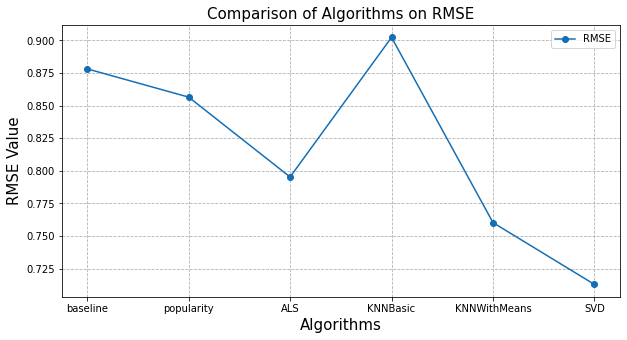

In [77]:
# plot rmse values of implemented models
plt.figure(figsize=(10,5))


plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(model_list, rmse_list, label='RMSE', color='#146EB4', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

## Section 3

#Text Preprocessing and sentiment analysis

In [44]:
df1.show(5,False)

+----------+--------------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [45]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag
import string
import re

# remove non ASCII characters 
def strip_non_ascii(string):
    stripped = (c for c in string if 0 < ord(c) < 127) # remove non ASCII characters , ord() checks if a user’s name contains a special character.
    return ''.join(stripped)

# setup pyspark udf function
strip_non_ascii_udf = udf(strip_non_ascii, StringType())

In [46]:
dtext = type_df.withColumn('review',strip_non_ascii_udf(df1['review']))
dtext.show(5,False)

+----------+--------------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [47]:
# fixed abbreviation
def fix_abbreviation(data_str):
    data_str = data_str.lower()
    data_str = re.sub(r'\bthats\b', 'that is', data_str)
    data_str = re.sub(r'\bive\b', 'i have', data_str)
    data_str = re.sub(r'\bim\b', 'i am', data_str)
    data_str = re.sub(r'\bya\b', 'yeah', data_str)
    data_str = re.sub(r'\bcant\b', 'can not', data_str)
    data_str = re.sub(r'\bdont\b', 'do not', data_str)
    data_str = re.sub(r'\bdon\b', 'do not', data_str)
    data_str = re.sub(r'\bwont\b', 'will not', data_str)
    data_str = re.sub(r'\bid\b', 'i would', data_str)
    data_str = re.sub(r'wtf', 'what the fuck', data_str)
    data_str = re.sub(r'\bwth\b', 'what the hell', data_str)
    data_str = re.sub(r'\br\b', 'are', data_str)
    data_str = re.sub(r'\bu\b', 'you', data_str)
    data_str = re.sub(r'\bk\b', 'OK', data_str)
    data_str = re.sub(r'\bsux\b', 'sucks', data_str)
    data_str = re.sub(r'\bno+\b', 'no', data_str)
    data_str = re.sub(r'\bcoo+\b', 'cool', data_str)
    data_str = re.sub(r'rt\b', '', data_str)
    data_str = data_str.strip()
    return data_str
# setup pyspark udf function
fix_abbreviation_udf = udf(fix_abbreviation, StringType())

In [48]:
dtext = dtext.withColumn('review',fix_abbreviation_udf(dtext['review']))
dtext.show(5,False)

+----------+--------------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [49]:
def remove_features(data_string):
    # convert to lowercase
    data_string = data_string.lower()
    # remove hyperlinks
    data_string = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?').sub(' ', data_string)
    # remove @mentions
    data_string = re.compile('@(\w+)').sub(' ', data_string)
    # remove puncuation
    #data_string = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', data_string)
    # remove numeric 'words'
    data_string = re.compile('(\\d+)').sub(' ', data_string)
    # remove non a-z 0-9 characters and words shorter than 1 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_string.split():
        if list_pos == 0:
            if re.compile("^[a-z0-9_.]+$").match(word) and len(word) > 1:
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if re.compile("^[a-z0-9_.]+$").match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
    # remove unwanted space, *.split() will automatically split on
    # whitespace and discard duplicates, the " ".join() joins the
    # resulting list into one string.
    return " ".join(cleaned_str.split())
# setup pyspark udf function
remove_features_udf = udf(remove_features, StringType())

In [50]:
dtext = dtext.withColumn('review',remove_features_udf(dtext['review']))
dtext.show(5,False)

+----------+--------------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [51]:
from pyspark.sql.types import FloatType
nltk.download('vader_lexicon') # VADER : Valence Aware Dictionary and sEntiment Reasoner.
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentiment_analysis(text):
  analyzer = SentimentIntensityAnalyzer()
  return analyzer.polarity_scores(text)['compound']
# setup pyspark udf function
sentiment_analysis_udf = udf(sentiment_analysis , FloatType())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [52]:
dtext = dtext.withColumn("sentiment_score", sentiment_analysis_udf(dtext['review'] ))
dtext.show(5,True)


+----------+--------------+------+--------------------+-------------+--------------+---------------+
|product_ID|   customer_ID|rating|              review|product_Index|customer_Index|sentiment_score|
+----------+--------------+------+--------------------+-------------+--------------+---------------+
|B00G8U2O0U|A1CNQTCRQ35IMM|   3.0|enjoyed the two m...|          522|           771|         0.6342|
|B0055PMJMW|A1CNQTCRQ35IMM|   4.0|suicide run by mi...|        10675|           771|         0.5122|
|B005D75Z8C|A1CNQTCRQ35IMM|   4.0|about reacher whe...|         3364|           771|        -0.5859|
|B007FIIF34|A1CNQTCRQ35IMM|   2.0|insufferable prox...|         5346|           771|        -0.7478|
|B00D4KG0DE|A1CNQTCRQ35IMM|   3.0|mercenary by c.l....|         1640|           771|          0.952|
+----------+--------------+------+--------------------+-------------+--------------+---------------+
only showing top 5 rows



Let's find the average of sentiment scores for each product. This will be used to filter out final recomendation.

In [53]:
dtext_ordred = dtext.groupBy("product_ID").mean('sentiment_score').sort(col('avg(sentiment_score)').desc())
#dtext_ordred.show()

In [79]:
# sentiment distribution
dtext1=dtext.withColumn("sentiment",F.when(F.col('sentiment_score')>=0.1,'positive')\
                        .otherwise(F.when(F.col("sentiment_score")<=-0.1,'neg')\
                        .otherwise('neutral')))


In [80]:
sentiment_pandas = dtext1.groupBy('sentiment').count().toPandas()
sentiment_pandas


,sentiment,count
0,positive,173964
1,neg,17067
2,neutral,5159


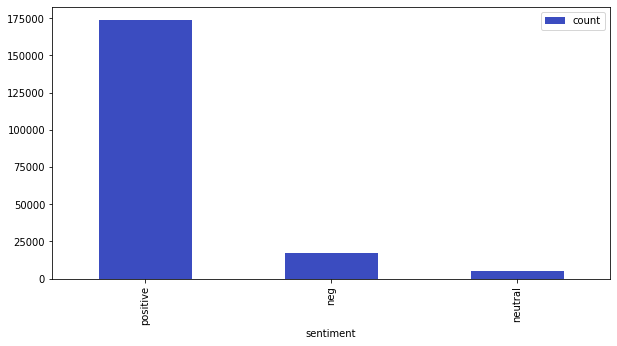

In [81]:
sentiment_pandas.plot(kind='bar', x='sentiment', y='count', colormap='coolwarm', figsize =(10,5), title = '')


## Section 4 

## final Recomendations


In [54]:
# Recommended 10 products from Collaborative filtering system (SVD)
items =list(top_n.items()) 

In [55]:
# list of products ordered in descending order of average sentiment scores
frame2=dtext_ordred.toPandas() # convert to pandas dataframe

In [56]:
# function to get final 5 recomendations
def my_fun(user_id):
  for i in range(len(items)):
    if user_id == items[i][0]:
      frame1 = pd.DataFrame(items[i][1], columns =['product_ID','rating'])
      frame3=frame1.set_index('product_ID').join(frame2.set_index('product_ID')).sort_values(by=['avg(sentiment_score)'],ascending=False)[0:5]
      return frame3


In [57]:
# final 5 recomendations for Reeding Renee, customer id = A1ZCEJEA67P6DE
my_fun('A1ZCEJEA67P6DE')

,rating,avg(sentiment_score)
product_ID,,
B00IQYYYJ0,4.482238,0.914100
B00C6SI9UW,4.464350,0.871775
B004LLIGNM,4.118432,0.869914
B00E55HXLA,4.123048,0.833474
B00K3IQCQK,4.473289,0.814583
